In [1]:
import sys
import gc
import numpy as np
from models import *
from load import *
from dataclasses import dataclass
import multiprocessing as mp
from anim import make_plots, AnimationMaker, DataVisualizer
from multiprocessing import Pool
from trainer import Trainer
from torch import Tensor, nn
import torch
import matplotlib.pyplot as plt
from models_base import Dataset, get_device
from sklearn.linear_model import LinearRegression
from derivative import NormalizedPoissonRMSE

ROOT = "./Datas/Week 7"

class Progress:
    def __init__(self, pad = 200):
        self.pad = pad
    
    def rint(self, content: str):
        print(content.ljust(self.pad), end = '\r')
        self.pad = max(self.pad, len(content) + 1)

LATENT = 3

# A leaky sigmoid function
class NotSigmoid:
    def __init__(self, leakage = .1):
        self.leakage = leakage

    def __call__(self, x):
        return self.leakage * x + torch.sigmoid(x)

class Encoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.l1 = nn.Linear(4386, 1000)
        self.s1 = NotSigmoid()
        self.l2 = nn.Linear(1000, 300)
        self.s2 = NotSigmoid()
        self.l3 = nn.Linear(300, 50)
        self.s3 = nn.Sigmoid()

        # Use tanh for mu to constrain it around 0
        self.lmu = nn.Linear(50, LATENT)
        self.smu = nn.Tanh()

        # Use sigmoid for sigma to constrain it to positive values and around 1
        self.lsi = nn.Linear(50, LATENT)
        self.ssi = nn.Sigmoid()

        # Move device to cuda if possible
        device = get_device()
        zero = torch.tensor(0).float().to(device)
        one = torch.tensor(1).float().to(device)
        self.N = torch.distributions.Normal(zero, one)
        self.kl = torch.tensor(0)

    def forward(self, x):
        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Linear layers
        x = self.l1(x)
        x = self.s1(x)

        x = self.l2(x)
        x = self.s2(x)

        x = self.l3(x)
        x = self.s3(x)

        # mu + normalization
        mean = self.lmu(x)
        mean = self.smu(mean)

        # sigma to make sigma positive
        var = self.lsi(x)
        var = self.ssi(var)

        # z = mu + sigma * N(0, 1)
        z = mean + var * self.N.sample(mean.shape)

        # KL divergence
        # https://stats.stackexchange.com/questions/318184/kl-loss-with-a-unit-gaussian?noredirect=1&lq=1
        # https://stats.stackexchange.com/questions/335197/why-kl-divergence-is-non-negative
        # https://kvfrans.com/variational-autoencoders-explained/
        # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048
        self.kl = -.5 * (torch.log(var) - var - mean * mean + 1).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.l1 = nn.Linear(LATENT, 50)
        self.s1 = nn.Sigmoid()
        self.l2 = nn.Linear(50, 300)
        self.s2 = nn.Sigmoid()

        self.l3sc = nn.Linear(300, 1000)
        self.s3sc = NotSigmoid(0.5)
        self.l4sc = nn.Linear(1000, 2193)
        self.s4sc = NotSigmoid(0.5)

        self.l3ep = nn.Linear(300, 500)
        self.s3ep = nn.Sigmoid()
        self.l4ep = nn.Linear(500, 2193)
        self.s4ep = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.s1(x)

        x = self.l2(x)
        x = self.s2(x)

        ep = self.l3ep(x)
        ep = self.s3ep(ep)

        ep = self.l4ep(ep)
        ep = self.s4ep(ep)
        
        sc = self.l3sc(x)
        sc = self.s3sc(sc)

        sc = self.l4sc(sc)
        sc = self.s4sc(sc)

        x = torch.cat([ep, sc], dim = -1)
        return x

class PoissonVAE(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Q = 1.60217663e-19

# Use this with the debugger to create an ad hoc cuda memory watcher in profile txt
class CudaMonitor:
    # Property flag forces things to save everytime a line of code gets run in the debugger
    @property
    def memory(self):
        print("Logging memory")
        s = []
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    # Total numbers
                    total = 1
                    for i in obj.shape:
                        total *= i
                    s.append((total, f"Tensor: {type(obj)}, size: {obj.size()}, shape: {obj.shape}"))
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except Exception as e:
                pass
        s = [x[1] for x in sorted(s, key = lambda a: a[0], reverse = True)]
        with open("profile.txt", 'w') as f:
            f.write(f"Memory allocated: {torch.cuda.memory_allocated()}\n")
            f.write(f"Max memory allocated: {torch.cuda.max_memory_allocated()}\n")
            for y in s:
                f.write(y)
                f.write("\n")
        return "\n".join(s)
    
    def clear(self):
        torch.cuda.empty_cache()
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    del obj
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except Exception as e:
                pass

def load():
    ep = Dataset(load_elec_potential())
    sc = Dataset(load_space_charge() * (-Q))
    epsc = (ep + sc).clone().to_tensor().reshape(-1, 1, 4386)
    print(epsc.shape)
    return epsc

def train(epochs: int):
    noise_ = 0.01
    device = get_device()
    net = PoissonVAE().to(device).double()
    history = []
    mse = nn.MSELoss()
    poi = NormalizedPoissonRMSE()
    epsc = load().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    p = Progress()
    c = CudaMonitor()

    for epoch in range(epochs):
        for x in epsc:
            # Add some noise
            noisy_x = x + (torch.rand((1, 4386)) - 1/2).to(device).double() * noise_
            def closure():
                # Bring memory watcher in :)
                nonlocal c

                if torch.is_grad_enabled():
                    optimizer.zero_grad()

                x_hat = net(noisy_x)
                mse_loss_ep = mse(x[:, :2193], x_hat[:, :2193])
                mse_loss_sc = mse(x[:, 2193:], x_hat[:, 2193:])
                poi_loss = poi(x_hat[:, :2193], x_hat[:, 2193:])
                kl_diver = net.encoder.kl
                loss = mse_loss_ep + mse_loss_sc + poi_loss + kl_diver
                if loss.requires_grad:
                    loss.backward()

                nonlocal history
                history.append([mse_loss_ep.item(), mse_loss_sc.item(), poi_loss.item(), kl_diver.item()])

                nonlocal p
                mse1_, mse2_, poi_, kl_ = history[-1]
                p.rint(f"Elapsed {epoch} epochs with MSE: {mse1_:.7f}, {mse2_:.7f}, Poisson: {poi_:.7f}, KL divergence: {kl_:.7f}")

                return loss
            optimizer.step(closure)
    return net, history

In [2]:
net, history = train(1000)

torch.Size([101, 1, 4386])


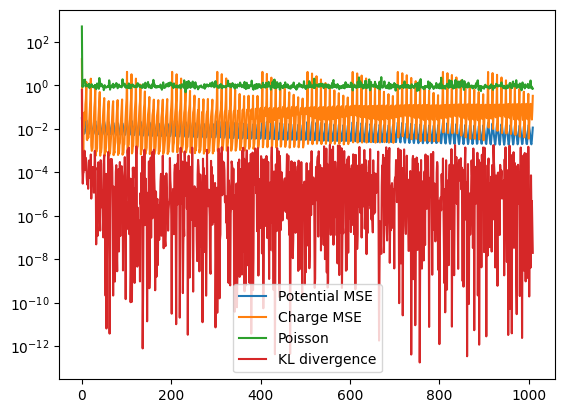

In [6]:
plt.figure()
plt.plot(history[::1000])
plt.yscale('log')
plt.legend(["Potential MSE", "Charge MSE", "Poisson", "KL divergence"])
plt.show()

In [7]:
from anim import make_anim
device = get_device()
ep = load_elec_potential().cpu().numpy()
sc = load_space_charge().cpu().numpy() * -Q
x = load().to(device)
with torch.no_grad():
    y = net(x)
    y_ep = y[:, :2193].reshape(-1, 129, 17).cpu().numpy()
    y_sc = y[:, 2193:].reshape(-1, 129, 17).cpu().numpy()
    make_anim(y_ep, ep, "./potential.gif", "Potential")
    make_anim(y_sc, sc, "./spacecharge.gif", "Space charge")

torch.Size([101, 1, 4386])
